# Redoing the Week 1 Notebook with Open Source Tools
# Fire up everything but GraphLab Create

In [1]:
%pylab inline
import pandas as pd
import statsmodels.formula.api as sm

Populating the interactive namespace from numpy and matplotlib


# Load some house value vs. crime rate data
Dataset is from Philadelphia, PA and includes average house sales price in a number of neighborhoods.  The attributes of each neighborhood we have include the crime rate ('CrimeRate'), miles from Center City ('MilesPhila'), town name ('Name'), and county name ('County').

In [2]:
sales = pd.read_csv('Philadelphia_Crime_Rate_noNA.csv')

In [3]:
sales.head()

,HousePrice,"HsPrc ($10,000)",CrimeRate,MilesPhila,PopChg,Name,County
0,140463,14.0463,29.7,10,-1.0,Abington,Montgome
1,113033,11.3033,24.1,18,4.0,Ambler,Montgome
2,124186,12.4186,19.5,25,8.0,Aston,Delaware
3,110490,11.0490,49.4,25,2.7,Bensalem,Bucks
4,79124,7.9124,54.1,19,3.9,Bristol B.,Bucks


# Exploring the data
The house price in a town is correlated with the crime rate of that town. Low crime towns tend to be associated with higher house prices and vice versa.

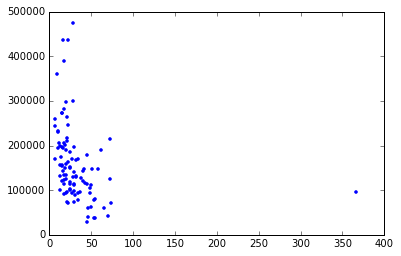

In [4]:
plt.plot(sales['CrimeRate'],sales['HousePrice'],'.')

# Fit the regression model using crime as the feature

In [5]:
model = sm.ols(formula = 'HousePrice ~ CrimeRate', data = sales)
fitted = model.fit()

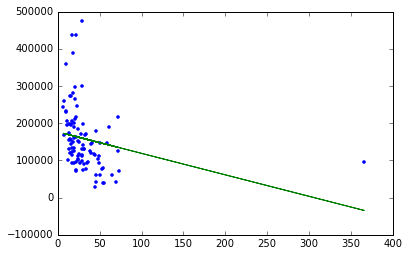

In [6]:
plt.plot(sales['CrimeRate'],sales['HousePrice'],'.',
        sales['CrimeRate'], fitted.fittedvalues, '-')

# Remove Center City and redo the analysis
Center City is the one observation with an extremely high crime rate, yet house prices are not very low.  This point does not follow the trend of the rest of the data very well.  A question is how much including Center City is influencing our fit on the other datapoints.  Let's remove this datapoint and see what happens.

Rather than finding Center City by searching on MilesPhila == 0, which strikes me as cheating, let's actually find it using Pandas' functionality.

In [7]:
CutCity = sales['CrimeRate'].idxmax()
sales[CutCity:(CutCity+1)]

,HousePrice,"HsPrc ($10,000)",CrimeRate,MilesPhila,PopChg,Name,County
62,96200,9.62,366.1,0,4.8,"Phila,CC",Phila


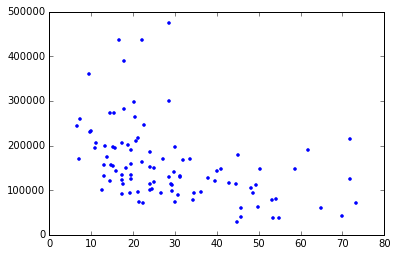

In [8]:
sales_noCC = sales.drop(sales.index[CutCity])
plt.plot(sales_noCC['CrimeRate'],sales_noCC['HousePrice'],'.')

### Refit our simple regression model on this modified dataset:

In [9]:
crime_model_noCC = sm.ols(formula = 'HousePrice ~ CrimeRate', data = sales_noCC)
fitted_noCC = crime_model_noCC.fit()

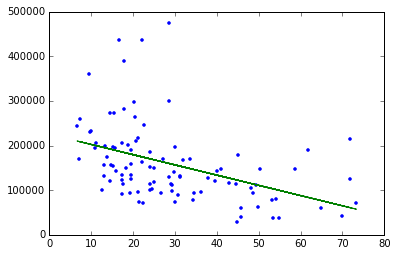

In [10]:
plt.plot(sales_noCC['CrimeRate'],sales_noCC['HousePrice'],'.',
        sales_noCC['CrimeRate'],fitted_noCC.fittedvalues,'-')

# Compare coefficients for full-data fit versus no-Center-City fit
Visually, the fit seems different, but let's quantify this by examining the estimated coefficients of our original fit and that of the modified dataset with Center City removed.
### Note that there's an error in the PhillyCrime.ipynb that will make the noCC fit above look incorrect
The line:

    plt.plot(sales_noCC['CrimeRate'],sales_noCC['HousePrice'],'.',
        sales_noCC['CrimeRate'],crime_model.predict(sales_noCC),'-')
        
Should read:

    plt.plot(sales_noCC['CrimeRate'],sales_noCC['HousePrice'],'.',
        sales_noCC['CrimeRate'],crime_model_noCC.predict(sales_noCC),'-')

In [11]:
fitted.params

Intercept    176629.408107
CrimeRate      -576.908128
dtype: float64

In [12]:
fitted_noCC.params

Intercept    225233.551839
CrimeRate     -2288.689430
dtype: float64

Above: We see that for the "no Center City" version, per unit increase in crime, the predicted decrease in house prices is 2,288.  In contrast, for the original dataset, the drop is only 576 per unit increase in crime.  This is significantly different!

### High leverage points: 
Center City is said to be a "high leverage" point because it is at an extreme x value where there are not other observations.  As a result, recalling the closed-form solution for simple regression, this point has the *potential* to dramatically change the least squares line since the center of x mass is heavily influenced by this one point and the least squares line will try to fit close to that outlying (in x) point.  If a high leverage point follows the trend of the other data, this might not have much effect.  On the other hand, if this point somehow differs, it can be strongly influential in the resulting fit.

### Influential observations:  
An influential observation is one where the removal of the point significantly changes the fit.  As discussed above, high leverage points are good candidates for being influential observations, but need not be.  Other observations that are *not* leverage points can also be influential observations (e.g., strongly outlying in y even if x is a typical value).

# Remove high-value outlier neighborhoods and redo analysis
Based on the discussion above, a question is whether the outlying high-value towns are strongly influencing the fit.  Let's remove them and see what happens.

In [13]:
sales_nohighend = sales_noCC[sales_noCC['HousePrice'] < 350000]

In [14]:
crime_model_nohighend = sm.ols(formula = 'HousePrice ~ CrimeRate',
                              data = sales_nohighend)
fitted_nohighend = crime_model_nohighend.fit()

In [15]:
fitted_nohighend.params

Intercept    199098.852670
CrimeRate     -1838.562649
dtype: float64

Above: We see that removing the outlying high-value neighborhoods has *some* effect on the fit, but not nearly as much as our high-leverage Center City datapoint.